# Standard Propensity Model: Brands in YouGov #

***Author:*** *Sourav Das*
<br>

---

<br>

**Run Time:** *4 min*

***Objective:*** to identify YouGov Pannellists who have high propensity to purchase products of the specific brand.  

*Caveats: Because the distribution of current customer is usually pretty low, we include panellists that have positive consideration of dreams or have positive purchase intent*

***Next Release: XGBOOST & CATBOOST CLASSIFIERS*** *to be tested for hp space & feature selection.*

# Enter Parameters #

*Get the brand id from the table: majestic-gizmo-216409.Converged_Production_Tools.brand_category_name_bi*

In [1]:
#Change the brand id below
brandid = [12008]
Client_name = 'Dominos' #Will help in parameterisation in web application
Segment_meaning = '1-Highest Propensity, 20-Lowest'
kpi_variable = ['purchase_intent', 'consider', 'current_own'] # options chosen from ['purchase_intent', 'consider', 'current_own']

## Improve memory allocation ##

In [3]:
# cat /proc/sys/vm/overcommit_memory

In [4]:
# !echo 1 > /proc/sys/vm/overcommit_memory
# !echo 2 | sudo tee /proc/sys/vm/overcommit_memory

# Extract data for training Propensity Model #

*We use **Demographics and Psychographics features** for modelling. There are c.1850 such features that have been imputed as part of Gap modelling project.*

In [2]:
import pandas as pd
from pandas.io import gbq

def bq_query_to_df(query):
 
  from google.cloud import bigquery
  import os
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'converged_havas_de_json.json'
 
  # print('Fetch Data for query:', sep='\n')
  client = bigquery.Client(project='majestic-gizmo-216409')
  return client.query(query).to_dataframe()

In [3]:
from datetime import datetime

start_time = datetime.now()
import pandas as pd
from google.cloud import bigquery

#demographics gap filled data
query1 = """
SELECT * from `majestic-gizmo-216409.Yougov_RLD_Gapfilling.demographics_gapfilled_v2`""" 
#gap filled demographics table

demographic_df = bq_query_to_df(query1)

#psychographics gap filled data

query2 = """
SELECT * from `majestic-gizmo-216409.Converged_Production_Tools.psychographics_gap_filling_mice_part2` """ 
#gap filled psychographics table
psychographic_df = bq_query_to_df(query2)

brandid_str = ','.join(str(i) for i in brandid)

# brandid_str = '(' + ','.join(str(id) for id in brandid) + ')'

#kpi case statement combination based on what is used as kpi variable.
kpi_combinations = {
    'purchase_intent': "case when purchase_intent = '{brandid_str}' then 1 else 0 end as KPI",
    'consider': "case when consider = '1' then 1 else 0 end as KPI",
    'current_own': "case when current_own = '1' then 1 else 0 end as KPI",
    'purchase_intent_consider': "case when purchase_intent = '{brandid_str}' or consider = '1' then 1 else 0 end as KPI",
    'purchase_intent_current_own': "case when purchase_intent = '{brandid_str}' or current_own = '1' then 1 else 0 end as KPI",
    'consider_current_own': "case when consider = '1' or current_own = '1' then 1 else 0 end as KPI",
    'purchase_intent_consider_current_own': "case when purchase_intent = '{brandid_str}' or consider = '1' or current_own = '1' then 1 else 0 end as KPI",
}

kpi_key = '_'.join(kpi_variable)
kpi_case_statement = kpi_combinations.get(kpi_key, "case when purchase_intent = '1' or consider = '1' or current_own = '1' then 1 else 0 end as KPI")

#kpi data
query3 =f"""

With brands as (
            SELECT
                      a.yougovid as yougov_id,
                      MAX(CASE WHEN a.variable = 'current_own' THEN a.value ELSE NULL END) current_own,
                      MAX(CASE WHEN a.variable = 'aided' THEN a.value ELSE NULL END) aided,
                      MAX(CASE WHEN a.variable = 'consider' THEN a.value ELSE NULL END) consider,
                      MAX(CASE WHEN a.variable = 'likelybuy' THEN a.value ELSE NULL END) purchase_intent
             FROM    
             
             (SELECT CASE WHEN VARIABLE = 'likelybuy' and VALUE is not null 
                          THEN CAST(VALUE AS INTEGER) ELSE brand_id END as brand_id
                   ,*EXCEPT(brand_id)
                FROM `majestic-gizmo-216409.Converged_Production_Tools.bi_response_copy`
             ) AS a
        
        INNER JOIN (
          SELECT
                yougovid as yougov_id,
                variable,
                value,
                MAX(date) AS date
           FROM `majestic-gizmo-216409.Converged_Production_Tools.bi_response_copy`
          WHERE brand_id in ({brandid_str})
            and variable in ('current_own','aided','consider')
           and value in ('0', '1', '2')
          GROUP BY
            yougovid,
            variable,
            value 
            
          UNION ALL

          SELECT
                yougovid as yougov_id,
                variable,
                value,
                MAX(date) AS date
           FROM `majestic-gizmo-216409.Converged_Production_Tools.bi_response_copy`
          WHERE variable in ('likelybuy')
            and value in ('{brandid_str}')
          GROUP BY
            yougovid,
            variable,
            value 
            
            
            
            ) AS b
        ON
              a.yougovid = b.yougov_id
          AND a.variable = b.variable
          AND a.date = b.date
        WHERE brand_id in ({brandid_str})
          and a.variable in ('current_own','aided','consider','likelybuy')
          and a.value in ('0', '1', '2' ,'{brandid_str}')
     GROUP BY  a.yougovid) 
 select yougov_id
       ,{kpi_case_statement}
  from brands
  where aided = '1'
  
"""

# parameters = [bigquery.ArrayQueryParameter('brandid', 'ARRAY<INT64>', brandid)]

kpi_df = bq_query_to_df(query3)


print(demographic_df.shape)
print(psychographic_df.shape)
print(kpi_df.shape)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

BadRequest: 400 No matching signature for operator CASE; all THEN/ELSE arguments must be coercible to a common type but found: INT64, STRING; actual argument types (WHEN THEN) ELSE: (BOOL STRING) INT64 at [12:22]

Location: europe-west2
Job ID: 8fc6fae3-1a64-4ca0-ab73-f0cbb8cb8080


## Convert Object to Int/Float ##

In [4]:
demographic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370024 entries, 0 to 370023
Columns: 247 entries, yougov_id to pdl_price_increase_uk_8
dtypes: object(247)
memory usage: 697.3+ MB


In [5]:
psychographic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370024 entries, 0 to 370023
Columns: 210 entries, yougov_id to attitudes_agree_a6d25d40_6266_11e7_838c_0ec8b917c582
dtypes: float64(209), object(1)
memory usage: 592.8+ MB


In [6]:
kpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130270 entries, 0 to 130269
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   yougov_id  130270 non-null  object
 1   KPI        130270 non-null  Int64 
dtypes: Int64(1), object(1)
memory usage: 2.1+ MB


In [7]:
demographic_df.set_index('yougov_id', inplace = True)
psychographic_df.set_index('yougov_id', inplace = True)
kpi_df.set_index('yougov_id', inplace = True)

In [8]:
demographic_df = demographic_df.apply(pd.to_numeric, errors='coerce')

In [9]:
demographic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370024 entries, FRGTTOSDUTEVIH5ZK6GB4YKFCE to ZSDG3RYKNKKTE5LBENBLM5RRAU
Columns: 246 entries, weights to pdl_price_increase_uk_8
dtypes: float64(1), int64(245)
memory usage: 697.3+ MB


In [10]:
# initialize a variable to keep track of the maximum number of categories/values
max_categories = 0

# create a list of column names excluding 'yougov_id' and 'weights'
column_list = [col for col in demographic_df.columns if col not in ['yougov_id', 'weights']]

# loop through each column in the dataframe
for col in demographic_df[column_list].columns:
    # get the number of unique categories/values in the column
    num_categories = len(demographic_df[col].unique())
    # update the maximum number of categories if necessary
    if num_categories > max_categories:
        max_categories = num_categories
        variable_with_max_categories = col

# print the variable with the maximum number of categories/values
print('The variable with the maximum number of categories/values is:', variable_with_max_categories)

The variable with the maximum number of categories/values is: pdl_country_of_birth


In [14]:
# missing_counts = kpi_df.isna().sum() / len(kpi_df)

## Fill Demographics Variables ##

In [11]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

X = pd.DataFrame(demographic_df)
demog_filled = DataFrameImputer().fit_transform(demographic_df)

### Encode Demographics Variables ###

In [12]:
# demog_filled.set_index('yougov_id', inplace=True)

# demog_filled = demog_filled.drop(['pdlc_age','pdlc_generation','pdl_profile_oshlthau','pdlc_Macro_BARB_region'
# ,'pdlc_profile_govregldn','pdl_profile_GOR', 'pdlc_ONS_urban'], axis = 1)

column_list2 = [col for col in demographic_df.columns if col not in ['yougov_id', 'weights']]


demographic_encoded = pd.get_dummies(demographic_df, columns = column_list2)
# demog_dummy.reset_index(inplace = True)
demographic_encoded.shape

(370024, 2138)

In [13]:
demographic_df.shape

(370024, 246)

## Convert Psychographics to binary ##

In [18]:
# psychographic_df.set_index('yougov_id', inplace = True)
# psychographic_df = psychographic_df.replace([9,8,7,6,5,4,3,2,1,-1,-2,-3],[1,1,1,1,1,1,0,0,0,0,0,0])
# psychographic_df.reset_index(inplace = True)
# psychographic_df.head()

## Create Training & Prediction Datasets ##

In [14]:
#Training Dataset has KPI values
import pandas as pd
# merge the dataframes together
df_original = demographic_df.merge(psychographic_df, on='yougov_id').merge(kpi_df, on='yougov_id')
df_training = demographic_encoded.merge(psychographic_df, on='yougov_id').merge(kpi_df, on='yougov_id')
df_training.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


,weights,pdlc_profile_govregldn_1,pdlc_profile_govregldn_2,pdlc_profile_govregldn_3,pdlc_profile_govregldn_4,pdlc_profile_govregldn_5,pdlc_profile_govregldn_6,pdlc_profile_govregldn_7,pdlc_profile_govregldn_8,pdlc_profile_govregldn_9,...,attitudes_agree_bdccaf60_a663_11e6_b2db_005056901c24,attitudes_agree_4170cf00_28e6_11e6_a405_005056900127,attitudes_agree_83202325_0cdc_11e8_a9fb_72f77b492c2d,attitudes_agree_6972cc35_1307_11e8_a288_aaf6ce8c0f17,attitudes_agree_17d91685_812b_11e8_ba38_fe820fe0f7d2,attitudes_agree_2f2f0770_28e2_11e6_a405_005056900127,attitudes_agree_4078c1b0_8679_11e7_8bc3_226c21931831,attitudes_agree_2c777820_6f1a_11e8_9e4d_d2bb2aee761e,attitudes_agree_a6d25d40_6266_11e7_838c_0ec8b917c582,KPI
yougov_id,,,,,,,,,,,,,,,,,,,,,
VJOP5EAKG23YU2FVA55MQONZMQ,0.135072,0,0,0,0,0,1,0,0,0,...,4.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,1.0,0
F5WMXKTIRPKK5HFOBGXOTXUL3E,0.528796,0,0,0,0,0,0,0,0,0,...,1.0,2.0,4.0,3.0,3.0,3.0,3.0,3.0,1.0,0
ZIWW3NO2SK3KKZICOZMAACAXGM,0.721214,0,0,0,0,0,0,0,0,0,...,3.0,1.0,3.0,2.0,2.0,3.0,1.0,3.0,3.0,0
GRJBJ74PGNUQSPCH73KQCJVEXI,3.117279,0,0,0,0,0,0,0,0,0,...,3.0,3.0,2.0,1.0,3.0,1.0,2.0,4.0,2.0,0
VKJAB57OBIITQ63W7VJ7EFTMRY,0.472625,0,0,0,0,0,0,0,0,0,...,2.0,1.0,3.0,2.0,3.0,3.0,3.0,2.0,1.0,0


In [15]:
#Prediction dataset doesn't have KPI
import pandas as pd
df_prediction  = demographic_df.merge(psychographic_df, how = 'inner', left_on = 'yougov_id', right_on = 'yougov_id')
df_prediction.head()

,weights,pdlc_profile_govregldn,pdl_profile_socialgrade_cie,pdl_profile_work_type,pdlc_age,pdl_profile_gender,pdlc_ONS_urban,pdl_profile_work_stat,pdl_country_of_birth,pdlc_children_aged_18_under,...,issues_scale_94da41c0_b364_11e3_90f3_005056900127,attitudes_agree_bdccaf60_a663_11e6_b2db_005056901c24,attitudes_agree_4170cf00_28e6_11e6_a405_005056900127,attitudes_agree_83202325_0cdc_11e8_a9fb_72f77b492c2d,attitudes_agree_6972cc35_1307_11e8_a288_aaf6ce8c0f17,attitudes_agree_17d91685_812b_11e8_ba38_fe820fe0f7d2,attitudes_agree_2f2f0770_28e2_11e6_a405_005056900127,attitudes_agree_4078c1b0_8679_11e7_8bc3_226c21931831,attitudes_agree_2c777820_6f1a_11e8_9e4d_d2bb2aee761e,attitudes_agree_a6d25d40_6266_11e7_838c_0ec8b917c582
yougov_id,,,,,,,,,,,,,,,,,,,,,
FRGTTOSDUTEVIH5ZK6GB4YKFCE,0.048625,10,1,1,74,2,3,1,1,2,...,1.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,3.0,1.0
VJOP5EAKG23YU2FVA55MQONZMQ,0.135072,6,1,1,58,1,3,1,1,2,...,0.0,4.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,1.0
KF3Y72AF5XZYONZWSOXCX65HL4,0.336475,8,1,1,68,2,3,1,1,2,...,2.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0,0.0
NREZ4PO6FMQXFBH6WVGQU5E2BI,1.821622,8,1,1,67,1,1,1,15,2,...,3.0,2.0,1.0,3.0,3.0,2.0,3.0,1.0,2.0,1.0
VKPF7B6LTUREAVH4NJWSM7TWH4,0.137971,9,1,1,65,1,3,1,1,2,...,1.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,0.0


# Training the Model #

## Loading Packages ##

In [16]:
#@title Loading Packages 
#Data Manipulation
import numpy as np
import pandas as pd
#import pandasql as ps #allows you to run SQL on dataframe objects
#import math

#standard packages
import io, os, sys, types, time, datetime, math, random, requests, subprocess, tempfile


# Visualization 
%matplotlib inline

import matplotlib.pyplot as plt
# import missingno
import seaborn as sns
#from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics.gofplots import ProbPlot
from pylab import rcParams

plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=10)
plt.rc('axes', titlesize=15)

#pd.options.display.float_format = '{:,.0f}'.format 
pd.options.display.float_format = '{:,.3f}'.format #upto 3 decimal points

# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler


# Machine learning & Stats
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#import tensorflow as tf

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from collections import Counter
from sklearn import datasets, linear_model
from pandas.plotting import autocorrelation_plot

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

#run the code in anaconda prompt
#conda install pandas-gbq -c conda-forge

import pandas as pd
from pandas.io import gbq

## Data Pre-processing for Training ##

*Remove a few features and then one-hot encoding is done*

In [17]:
#@title Data Pre-processing 
# df_training_copy = df_training.copy()
# df_training_copy.set_index('yougov_id', inplace=True)

#Variable Set Up
# df_training.set_index('yougov_id', inplace=True)
y = df_training['KPI']
X = df_training.drop(['KPI'], axis = 1)
X.shape

(89739, 2347)

## Distribution of Response ##

In [18]:
#@title Distribution of Response
df_training.KPI.value_counts(normalize = True)
# df_training_copy.KPI.value_counts()

0   0.851
1   0.149
Name: KPI, dtype: Float64

In [24]:
# # #@title Balancing the dataset (Optional)
# #from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 0, sampling_strategy=0.7)

# # Import train_test_split function
# from sklearn.model_selection import train_test_split

# X_res, y_res = sm.fit_resample(X, y)#

## Data Partition in Training & Test (70-30) and Balance the Dataset ##

In [187]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

y=y.astype('int')

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y) # 70% training and 30% test

# Calculate the percentage of '1' in the target variable
percentage_of_1 = y_train.value_counts(normalize=True).get(1, 0)

# Apply SMOTE if the percentage of '1' is less than 40%
if percentage_of_1 < 0.4:
    sm = SMOTE(random_state=0, sampling_strategy='auto')
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
else:
    X_train_res, y_train_res = X_train, y_train

In [188]:
pd.DataFrame(y_train_res).value_counts(normalize=True)

KPI
0     0.500
1     0.500
dtype: float64

## Testing a Voting Classifier ##

In [26]:
# #@title Testing a Voting Classifier
# start_time = datetime.now()

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC

# log_clf = LogisticRegression(random_state = 0)
# rnd_clf = RandomForestClassifier(random_state = 0)
# svm_clf = SVC(random_state = 0)

# voting_clf = VotingClassifier( 
#     estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
#     voting = 'hard')
# voting_clf.fit(X_train, y_train)

# end_time = datetime.now()
# print('Duration: {}'.format(end_time - start_time))

## Check Accuracy of Voting Classifier ##

In [27]:
# #@title Check the accuracy of the voting classifier
# from datetime import datetime
# start_time = datetime.now()
# from sklearn.metrics import accuracy_score 

# for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     #print(clf._class_,_name_,accuracy_score(y_test, y_pred))
#     print(accuracy_score(y_test, y_pred))

# end_time = datetime.now()
# print('Duration: {}'.format(end_time - start_time))

## Feature Selection - RFECV & by Feature Importance Score from RF ##

**Very Important Step** This step shows us the Optimal number of ***econded** features adequate for the model. But it is important that we include the Original feature and not restrict it to the encoded feature alone. So, for example if RFECV shows encoded feature pdl_profile_socialgrade_cie_C2 is a good predictor, we have include the original feature pdl_profile_socialgrade_cie in training the model. This is a piece of literature that should not be ignored.*

1. *Run a Basic Model*
2. *Use feature importance to cut down to 250 encoded features*
3. *Run RFECV and select optimal number of features on the 250 features selected above*
4. *Find original/parent feature & run the final model*

### 1 Run a Basic XGBOOST Model ###

*XGBOOST Cannot handle special characters in feature name. Random Forest can handle it.*

In [189]:
#Execute this block if you are running an XGBOOST Model
encoded_cols = X_train.columns
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_res.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns  = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [29]:
# pip install xgboost

In [190]:
#@title Run a Random Forest Model
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier


#Create a Gaussian Classifier
# clf=RandomForestClassifier(n_estimators=500, criterion = "entropy", oob_score = True, random_state=0, n_jobs = -1)
clf=XGBClassifier(n_jobs=80, random_state=80, n_estimators=500, objective="binary:logistic", eval_metric="auc")#,max_delta_step=2
#n_jobs=-1 uses all the cores. Notify the team members if required to run this. 

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_res,y_train_res)

y_pred_train = clf.predict(X_train_res)
y_pred=clf.predict(X_test)
prob_rf = clf.predict_proba(X_test)[:,1]
#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print(prob_rf)

[0.   0.05 0.24 ... 0.5  0.25 0.15]


In [191]:
prob_rf.shape

(26922,)

In [192]:
prob_rf.sum()

2868.8362

### 2 Use feature importance to cut down to 100 variables ###

In [193]:
X_train_res.columns = encoded_cols
X_test.columns = encoded_cols

In [194]:
#@title Feature Selection
importance = clf.feature_importances_
df_imp = pd.DataFrame(importance)
df_features = pd.DataFrame(X_train.columns.T)
df_features.columns = ['features']
df_imp.columns = ['importance_score']
df_feature_importance = pd.merge(df_features, df_imp, how = 'inner', left_index=True, right_index=True)
df_feature_importance['importance_score_1000'] = df_feature_importance.importance_score*1000
df_feature_importance['rank'] = df_feature_importance['importance_score_1000'].rank(ascending=False)
df_selected_feature = df_feature_importance.loc[(df_feature_importance['rank'] <= 250)]
df_remove_feature = df_feature_importance.loc[(df_feature_importance['rank'] > 250)]
remove_feature = list(df_remove_feature.features.unique())
df_selected_feature.sort_values('rank')

,features,importance_score,importance_score_1000,rank
490,pdl_household_type_UK_1_1,0.043,42.571,1.000
517,pdl_grandparent_child_ages_97_0,0.036,35.940,2.000
110,pdl_profile_gender_1,0.033,33.407,3.000
489,pdl_household_type_UK_1_0,0.028,28.311,4.000
482,pdl_pets_99_1,0.024,23.797,5.000
...,...,...,...,...
397,pdl_profile_household_children_2,0.000,0.457,246.000
1104,pdl_cie_manage_3,0.000,0.456,247.000
921,pdl_posedu_24,0.000,0.455,248.000
727,pdl_employ_jobtitle_2020_299,0.000,0.454,249.000


### RFECV on Selected Features ###

In [35]:
# X = X.drop(remove_feature , axis=1)

# #@title Data Partition (70-30 split)
# # Import train_test_split function
# from sklearn.model_selection import train_test_split

# # Split dataset into training set and test set
# # X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state = 0) # 70% training and 30% test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0) # 70% training and 30% test

In [36]:
# #@title RFECV for Feature Selection
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_error
# from xgboost import XGBClassifier
# from sklearn.feature_selection import RFECV

# names = X.columns
# clf_rfecv = XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100, objective="binary:logistic", eval_metric="auc")
# # clf_rfecv = RandomForestClassifier(n_estimators=100, criterion = "entropy", oob_score = True, random_state=0, n_jobs = -1)
# selector = RFECV(clf_rfecv, step= 1, n_jobs=-1) 
# selector = selector.fit(X_train, y_train)
# selector.support_ 
# selector.ranking_

# # print("Feature Ranking: %s" % selector.ranking_)
# print("Optimal number of features : %d" % selector.n_features_)

# print ("Features sorted by their rank:")
# print (sorted(zip(map(lambda x: round(x, 4), selector.ranking_), names)))

# # Plot number of features VS. cross-validation scores
# plt.style.use('seaborn-whitegrid')
# plt.figure(figsize=(20,5)) 
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_);

# # Feature space could be subsetted like so:
# #X = X[X.columns[np.insert(selector.support_, 0, True)]]

In [37]:
# rfecv_selected_features = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), names)), columns = ['rank','features'])

## Build a Confusion Matrix ##

Confusion matrix, without normalization
[[22632   289]
 [ 3914    87]]
Normalized confusion matrix
[[0.99 0.01]
 [0.98 0.02]]


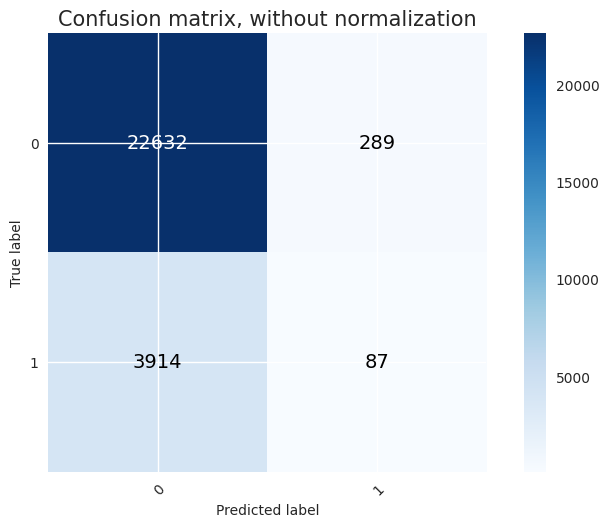

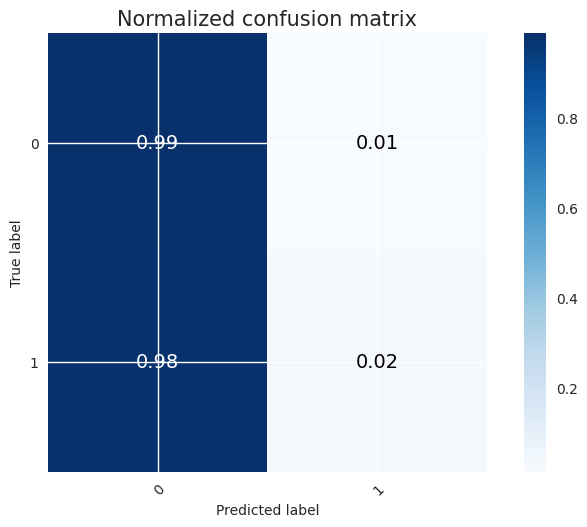

In [195]:
#@title Build a Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#classes  = abc1_df.abc1.unique()
def plot_confusion_matrix(y_test, y_pred, #classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_test, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, #classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Overfitting Check ##

### Accuracy on Training Dataset ###

In [196]:
print(metrics.classification_report(y_train_res, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     53480
           1       1.00      0.98      0.99     53480

    accuracy                           0.99    106960
   macro avg       0.99      0.99      0.99    106960
weighted avg       0.99      0.99      0.99    106960



### Accuracy on Test Dataset ###

In [197]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92     22921
           1       0.23      0.02      0.04      4001

    accuracy                           0.84     26922
   macro avg       0.54      0.50      0.48     26922
weighted avg       0.76      0.84      0.78     26922



### Choose optimal encoded features ###

In [41]:
# #Execute this if RFECV is run
# df_selected_feature = df_feature_importance.loc[(df_feature_importance['rank'] <= selector.n_features_)]
# df_remove_feature = df_feature_importance.loc[(df_feature_importance['rank'] > selector.n_features_)]
# remove_feature = list(df_remove_feature.features.unique())

### Find the Original features of the encoded optimal features ###

In [198]:
parent_features = pd.DataFrame(df_original.columns)
parent_features.columns = ['original_features']
parent_features.head()

,original_features
0,weights
1,pdlc_profile_govregldn
2,pdl_profile_socialgrade_cie
3,pdl_profile_work_type
4,pdlc_age


In [43]:
# # Write data to excel
# df_selected_feature.to_excel('./Sourav/data/df_selected_feature.xlsx')
# parent_features.to_excel('./Sourav/data/parent_feature.xlsx')

In [199]:
print(df_selected_feature.shape)
print(parent_features.shape)

(250, 4)
(456, 1)


In [200]:
selected_parent_features = list(set(df_selected_feature.features).intersection(parent_features.original_features))
df_selected_feature_2 = pd.DataFrame(df_selected_feature.features).copy()
df_selected_feature_2 = df_selected_feature_2.query('features not in @selected_parent_features')

for col in df_selected_feature_2.features.values:
    #if " " in col:
        # print(col.rpartition("_")[0])
    selected_parent_features.append(col.rpartition("_")[0])

selected_parent_features= list(set(selected_parent_features))
selected_parent_features

['attitudes_agree_618a4fd0_99ee_11e7_9f92_d298beabf694',
 'pdl_employer_type_private_non_self',
 'attitudes_agree_83202325_0cdc_11e8_a9fb_72f77b492c2d',
 'attitudes_agree_8f34abf0_b7ef_11e7_b4a9_82b77015c6a6',
 'attitudes_agree_8e1ac2b5_0a19_11ea_9768_91d26831c94f',
 'attitudes_agree_cec10b10_5012_11e6_9bb2_0050569071a4',
 'pdl_former_employ',
 'attitudes_agree_40de00f5_1307_11e8_8e3b_bea5289e706c',
 'attitudes_agree_527067b0_d538_11e3_8434_005056900127',
 'pdlc_grandparent_yes_no',
 'attitudes_agree_cac3dd50_dfe8_11e7_8728_4e361292ccb6',
 'pdl_public_sector_type',
 'pdl_profile_gross_personal',
 'pdl_cie_drive',
 'pdl_management_level',
 'pdl_posIT',
 'personality_multi_c6585a50_0109_11e4_b75b_005056900044_9',
 'pdl_poseng',
 'pdl_life_events_next12months_NEW_97',
 'issues_scale_b670fbe0_b345_11e3_90f3_005056900127',
 'pdl_employ_decisionmaker_UK_98',
 'pdl_cie_estab_empnum_other',
 'pdl_selfcie_responsible',
 'pdl_profile_house_tenure',
 'pdl_cie_poshealth',
 'attitudes_agree_2008933

In [201]:
len(selected_parent_features)

162

## Run XGBOOST/Random Forest Reduced Features ##

In [202]:
demographic_df_fs = demographic_df.drop(columns=[col for col in demographic_df if col not in selected_parent_features])
psychographic_df_fs = psychographic_df.drop(columns=[col for col in psychographic_df if col not in selected_parent_features])

In [203]:
# demog_filled_fs.set_index('yougov_id', inplace=True)

# demog_filled_fs = demog_filled_fs.drop(['pdlc_age','pdlc_generation','pdl_profile_oshlthau','pdlc_Macro_BARB_region'
# ,'pdlc_profile_govregldn','pdl_profile_GOR', 'pdlc_ONS_urban'], axis = 1)

demographic_df_fs_encoded = pd.get_dummies(demographic_df_fs)
df_training_fs = demographic_df_fs_encoded.merge(psychographic_df_fs, on='yougov_id').merge(kpi_df, on='yougov_id')

In [204]:
#Variable Set Up
y = df_training_fs['KPI']
X = df_training_fs.drop(['KPI'], axis = 1)

In [205]:
#Execute this block if you are running an XGBOOST Model
encoded_cols = X.columns
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [207]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

y = y.astype('int')

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)  # 70% training and 30% test

# Calculate the percentage of '1' in the target variable
percentage_of_1 = y_train.value_counts(normalize=True).get(1, 0)

# Apply SMOTE if the percentage of '1' is less than 40%
if percentage_of_1 < 0.4:
    sm = SMOTE(random_state=0, sampling_strategy='auto')
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
else:
    X_train_res, y_train_res = X_train, y_train

# Create a XGB Classifier
clf_fs = XGBClassifier(n_jobs=80, random_state=42, n_estimators=1000, objective="binary:logistic", eval_metric="auc")

# Train the model using the training sets
clf_fs.fit(X_train_res, y_train_res)

y_pred_train = clf_fs.predict(X_train_res)
y_pred = clf_fs.predict(X_test)
prob_rf_fs = clf_fs.predict_proba(X_test)[:, 1]
print(prob_rf_fs)

[1.43e-05 1.99e-02 2.51e-02 ... 2.91e-01 3.60e-03 2.17e-01]


In [208]:
prob_rf_fs.shape

(26922,)

In [209]:
prob_rf_fs.sum()

2095.3745

In [210]:
X.columns = encoded_cols

In [211]:
X.shape

(89739, 162)

## Check Confusion Matrix ##

Confusion matrix, without normalization
[[22510   411]
 [ 3863   138]]
Normalized confusion matrix
[[0.98 0.02]
 [0.97 0.03]]


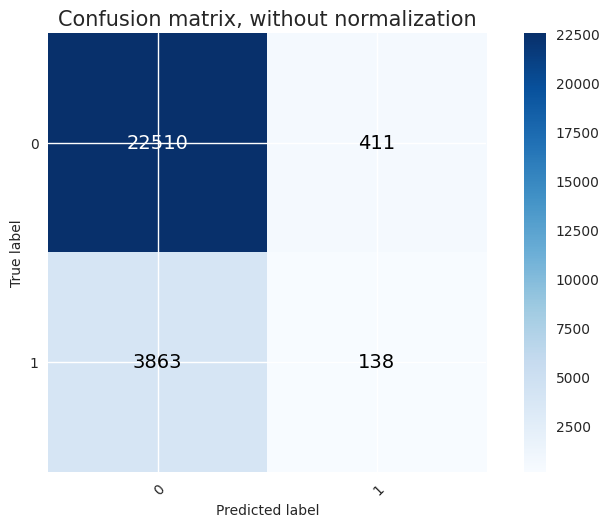

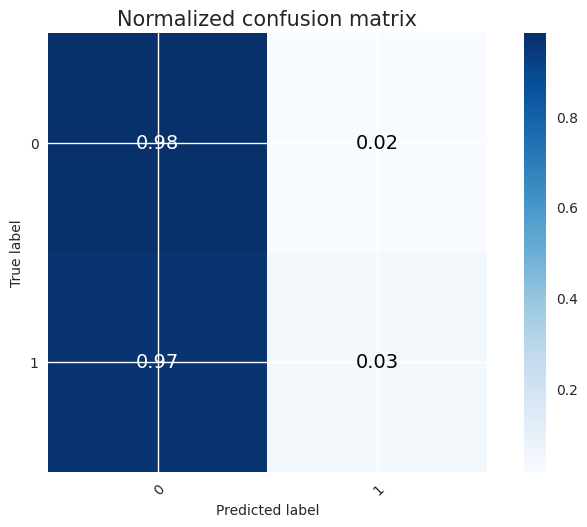

In [212]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, #classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Accuracy of Training Dataset ###

In [213]:
print(metrics.classification_report(y_train_res, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53480
           1       1.00      1.00      1.00     22920

    accuracy                           1.00     76400
   macro avg       1.00      1.00      1.00     76400
weighted avg       1.00      1.00      1.00     76400



### Accuracy of Test Dataset ###

In [214]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     22921
           1       0.25      0.03      0.06      4001

    accuracy                           0.84     26922
   macro avg       0.55      0.51      0.49     26922
weighted avg       0.76      0.84      0.79     26922



# Predict High Propensity Customers #


*   Extract Dataset from BigQuery where respondents have not responded to the KPI question
*   Remove features done at pre-processing
*   Recode Psychographic variables as in pre-processing for training model
*   Create X and Y variables
*   One hot encoding
*   Remove the features as identified in feature selection
*   Predict Probability and append to the dataset

In [59]:
# demographic_df_fs = demographic_df.set_index('yougov_id')
# psychographic_df_fs = psychographic_df.set_index('yougov_id')

# demographic_df_fs = demographic_df_fs.drop(columns=[col for col in demographic_df_fs if col not in selected_parent_features])
# psychographic_df_fs = psychographic_df_fs.drop(columns=[col for col in psychographic_df_fs if col not in selected_parent_features])

# demographic_df_fs.reset_index(inplace = True)
# psychographic_df_fs.reset_index(inplace = True)

# # X = pd.DataFrame(demographic_df)
# demog_filled_fs = DataFrameImputer().fit_transform(demographic_df)

In [60]:
# demog_filled_fs.set_index('yougov_id', inplace=True)

# demog_filled_fs = demog_filled_fs.drop(['pdlc_age','pdlc_generation','pdl_profile_oshlthau','pdlc_Macro_BARB_region'
# ,'pdlc_profile_govregldn','pdl_profile_GOR', 'pdlc_ONS_urban'], axis = 1)

# demog_filled_fs = pd.get_dummies(demog_filled_fs)
# demog_filled_fs.reset_index(inplace = True)

In [215]:
df_prediction_fs  = demographic_df_fs.merge(psychographic_df_fs, how = 'inner', left_on = 'yougov_id', right_on = 'yougov_id')
df_prediction_fs.head()

,pdlc_profile_govregldn,pdl_profile_socialgrade_cie,pdl_profile_work_type,pdlc_age,pdl_profile_gender,pdl_country_of_birth,pdlc_grandparent_yes_no,pdlc_oldest_child_hh,pdlc_youngest_child_hh,pdl_profile_household_children,...,attitudes_agree_ef485100_28e3_11e6_a405_005056900127,attitudes_agree_618a4fd0_99ee_11e7_9f92_d298beabf694,attitudes_agree_55fca685_1307_11e8_a288_aaf6ce8c0f17,attitudes_agree_89d34413_28e7_11e7_b3e6_d2249ae0b02d,issues_importance_69174610_97e7_11e4_90cd_005056900127,attitudes_agree_7723e660_0cdc_11e8_8e3b_bea5289e706c,issues_scale_99d7f500_9fb9_11e3_b2fd_005056900127,attitudes_agree_4170cf00_28e6_11e6_a405_005056900127,attitudes_agree_83202325_0cdc_11e8_a9fb_72f77b492c2d,attitudes_agree_6972cc35_1307_11e8_a288_aaf6ce8c0f17
yougov_id,,,,,,,,,,,,,,,,,,,,,
FRGTTOSDUTEVIH5ZK6GB4YKFCE,10,1,1,74,2,1,1,99,99,1,...,1.000,2.000,2.000,1.000,1.000,4.000,0.000,3.000,3.000,2.000
VJOP5EAKG23YU2FVA55MQONZMQ,6,1,1,58,1,1,2,99,99,1,...,1.000,4.000,3.000,1.000,1.000,4.000,0.000,3.000,4.000,3.000
KF3Y72AF5XZYONZWSOXCX65HL4,8,1,1,68,2,1,1,99,99,1,...,3.000,3.000,2.000,1.000,0.000,3.000,2.000,1.000,2.000,2.000
NREZ4PO6FMQXFBH6WVGQU5E2BI,8,1,1,67,1,15,1,99,99,1,...,3.000,3.000,3.000,1.000,0.000,4.000,2.000,1.000,3.000,3.000
VKPF7B6LTUREAVH4NJWSM7TWH4,9,1,1,65,1,1,2,99,99,1,...,3.000,3.000,3.000,1.000,1.000,3.000,1.000,2.000,3.000,2.000


## Replicating Data Pre-processing ##

In [62]:
# df_prediction_copy = df_prediction.copy()
# yougov_ids = df_prediction.yougov_id

In [216]:
#@title Replication Data Pre-processing 
df_prediction = df_prediction.drop(columns=[col for col in df_prediction if col not in selected_parent_features])

print(X.shape)
print(df_prediction.shape)

(89739, 162)
(370024, 162)


### Ensure the training and prediction dataset have the same number of variables ###

In [217]:
print(X.shape)
print(df_prediction_fs.shape)

(89739, 162)
(370024, 162)


### Append Probability to Prediction Dataset ###

In [218]:
prob_rf_fs = clf_fs.predict_proba(df_prediction_fs)[:,1]

In [219]:
propensity = pd.DataFrame(prob_rf_fs)
propensity.columns = ['probabilities']

In [220]:
df_prediction_fs.reset_index(inplace = True)
yougov_ids = df_prediction_fs['yougov_id']

In [221]:
propensity_dataset = pd.merge(yougov_ids, propensity, how = 'inner', left_index = True, right_index = True)
propensity_dataset.head()

,yougov_id,probabilities
0,FRGTTOSDUTEVIH5ZK6GB4YKFCE,0.002
1,VJOP5EAKG23YU2FVA55MQONZMQ,0.026
2,KF3Y72AF5XZYONZWSOXCX65HL4,0.008
3,NREZ4PO6FMQXFBH6WVGQU5E2BI,0.017
4,VKPF7B6LTUREAVH4NJWSM7TWH4,0.123


In [69]:
# !pip install pandasql

## Create 20 Bins - for propensity segments ##

*We shall create 20 equal(ish) sized groups based on the precision of probabilities. The ones with the highest probability (propensity) to convert/consider/purchase will have the bucket number **1**. This will allow us to choose various sizes of High propensity segments.*

In [222]:
import pandas as pd
# propensity_dataset_segment2 = propensity_dataset_segment.copy()

labels = []
i = 20
while i >= 1:
    labels.append(i)
    i -=1

propensity_dataset['Segment_bucket'] = pd.qcut(propensity_dataset['probabilities'], 20, precision = 1000, labels=labels)
propensity_dataset.head()

,yougov_id,probabilities,Segment_bucket
0,FRGTTOSDUTEVIH5ZK6GB4YKFCE,0.002,18
1,VJOP5EAKG23YU2FVA55MQONZMQ,0.026,11
2,KF3Y72AF5XZYONZWSOXCX65HL4,0.008,16
3,NREZ4PO6FMQXFBH6WVGQU5E2BI,0.017,13
4,VKPF7B6LTUREAVH4NJWSM7TWH4,0.123,5


### Check the Bin Probability Breakdown ###

In [223]:
propensity_dataset_agg = propensity_dataset.copy()
propensity_dataset_agg.drop('yougov_id', inplace = True, axis = 1)
propensity_agg = pd.DataFrame(propensity_dataset_agg.groupby('Segment_bucket').agg(['min', 'max']))
id_persegment = pd.DataFrame(propensity_dataset.groupby('Segment_bucket').yougov_id.nunique())
id_persegment.rename({'yougov_id': 'Panellists'}, axis=1, inplace=True)
pd.merge(propensity_agg, id_persegment, how = 'inner', left_index = True, right_index = True).sort_values('Segment_bucket', ascending=False)

,"(probabilities, min)","(probabilities, max)",Panellists
Segment_bucket,,,
1,0.463,0.997,18502
2,0.266,0.463,18501
3,0.183,0.266,18501
4,0.135,0.183,18501
5,0.103,0.135,18501
6,0.080,0.103,18501
7,0.063,0.080,18502
8,0.050,0.063,18501
9,0.040,0.050,18501


In [224]:
training_kpi = pd.DataFrame(y)
training_kpi.reset_index(inplace = True)

In [225]:
propensity_dataset_exc = propensity_dataset[~propensity_dataset.yougov_id.isin(training_kpi.yougov_id)]
propensity_dataset_exc.shape

(280285, 3)

In [74]:
# Write data to excel
# df_selected_feature.to_excel('./data/df_selected_feature.xlsx')
# propensity_dataset.to_csv('./data/qcut_test.csv')

### Concatenate Training & Prediction Dataset ###

In [226]:
df_training2 = training_kpi[['yougov_id', 'KPI']]
df_training2.rename({'KPI': 'Segment_bucket'}, axis=1, inplace=True)
df_training2=df_training2.replace([0],[20])
final_propensity_dataset_segment = pd.concat([propensity_dataset_exc[['yougov_id','Segment_bucket']], df_training2], ignore_index=True)
final_propensity_dataset_segment['Client'] = Client_name #change this
final_propensity_dataset_segment['Segment_bucket_meaning'] = Segment_meaning
final_propensity_dataset_segment.head()

,yougov_id,Segment_bucket,Client,Segment_bucket_meaning
0,FRGTTOSDUTEVIH5ZK6GB4YKFCE,18,Kia,"1-Highest Propensity, 20-Lowest"
1,KF3Y72AF5XZYONZWSOXCX65HL4,16,Kia,"1-Highest Propensity, 20-Lowest"
2,NREZ4PO6FMQXFBH6WVGQU5E2BI,13,Kia,"1-Highest Propensity, 20-Lowest"
3,VKPF7B6LTUREAVH4NJWSM7TWH4,5,Kia,"1-Highest Propensity, 20-Lowest"
4,SYI7UGFWPCKRSNRVEWVYGBMTDI,5,Kia,"1-Highest Propensity, 20-Lowest"


## Adding a datetime element to make the file name unique ##

In [227]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%Y%m%d%H%M%S")
print("date and time =", dt_string)

date and time = 20230425195102


In [228]:
final_propensity_dataset_segment['datetime'] = dt_string
final_propensity_dataset_segment.head()

,yougov_id,Segment_bucket,Client,Segment_bucket_meaning,datetime
0,FRGTTOSDUTEVIH5ZK6GB4YKFCE,18,Kia,"1-Highest Propensity, 20-Lowest",20230425195102
1,KF3Y72AF5XZYONZWSOXCX65HL4,16,Kia,"1-Highest Propensity, 20-Lowest",20230425195102
2,NREZ4PO6FMQXFBH6WVGQU5E2BI,13,Kia,"1-Highest Propensity, 20-Lowest",20230425195102
3,VKPF7B6LTUREAVH4NJWSM7TWH4,5,Kia,"1-Highest Propensity, 20-Lowest",20230425195102
4,SYI7UGFWPCKRSNRVEWVYGBMTDI,5,Kia,"1-Highest Propensity, 20-Lowest",20230425195102


## Load the Propensity Dataset Onto BigQuery for further Analysis ##

In [229]:
import pandas as pd
final_propensity_dataset_segment.to_csv(f'gs://data-science-drops/propensity_model/propensity_model_{brandid}_{dt_string}.csv', index = False)

In [79]:
# !pip install pandas-gbq

In [230]:
import pandas as pd

# set the credentials for BigQuery
project_id = 'majestic-gizmo-216409'
# credentials = 'path/to/credentials.json'

# set the name of the BigQuery dataset and table
dataset_name = 'Converged_Production_Tools'
table_name = 'fct_propensity_models_deduped'


# insert the DataFrame into the existing BigQuery table
final_propensity_dataset_segment.to_gbq(f'{dataset_name}.{table_name}', project_id=project_id
                                        , if_exists='append')

print(f'{len(final_propensity_dataset_segment)} rows added to {dataset_name}.{table_name}')

100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

370024 rows added to Converged_Production_Tools.fct_propensity_models_deduped


In [81]:
# def load_table_csv(table_id):

#     # [START bigquery_load_table_gcs_avro]
#     from google.cloud import bigquery
#     import os

#     # Construct a BigQuery client object.
#     client = bigquery.Client(project = 'majestic-gizmo-216409')  

#     # table_id = "your-project.your_dataset.your_table_name
#     # MAX_BAD_RECORDS = 100

#     #job_config = bigquery.LoadJobConfig(autodetect=True, source_format=bigquery.SourceFormat.CSV)
#     job_config = bigquery.LoadJobConfig(    
#         schema = [bigquery.SchemaField('yougov_id', 'STRING', mode='Nullable'),                 
#                   bigquery.SchemaField('Segment_bucket', 'INTEGER', mode='Nullable'),
#                   bigquery.SchemaField('client', 'STRING', mode='Nullable'),
#                   bigquery.SchemaField('segment_bucket_meaning', 'STRING', mode='Nullable'),
#                   bigquery.SchemaField('datetime', 'BigNumeric', mode='Nullable'),],skip_leading_rows =1, max_bad_records = 0, source_format=bigquery.SourceFormat.CSV)

#     uri = "gs://data-science-drops/propensity_model/propensity_model*.csv"

#     load_job = client.load_table_from_uri(uri, table_id, job_config=job_config)  # Make an API request.
#     load_job.result()  # Waits for the job to complete.

#     destination_table = client.get_table(table_id)
#     print("Loaded {} rows.".format(destination_table.num_rows))

In [82]:
# load_table_csv("majestic-gizmo-216409.Converged_Production_Tools.propensity_models")